In [1]:
import os
import re
import math
import typing
import warnings
from enum import Enum

import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
from scipy.stats import zscore
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split

from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important}; </style>"))

In [2]:
warnings.filterwarnings(
    action='ignore',
    message='înternal gelsd'
)

warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning
)

np.random.seed(1)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# Matplotlib set label size
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

In [4]:
sns.set_style('whitegrid')
sns.set_context(
    'notebook',
    font_scale=1,
    rc={
        'lines.linewidth': 2,
        'font.family': [u'times']
    }
)

## Loading Data

In [5]:
train_set = pd.read_csv('./data/train_set.csv', index_col=0)
test_set = pd.read_csv('./data/test_set.csv', index_col=0)

<AxesSubplot:>

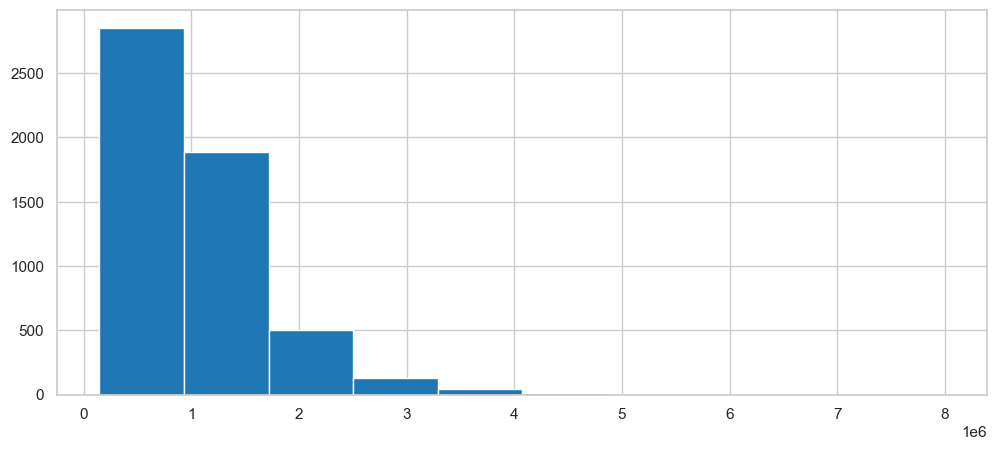

In [6]:
train_set.Price.hist()

<AxesSubplot:>

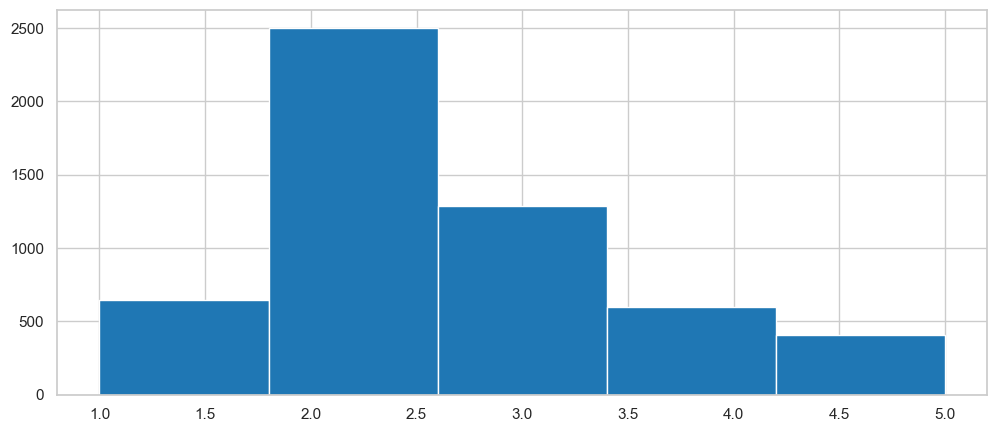

In [10]:
train_set['price_range'] = pd.cut(train_set.Price, bins=[.0, .5e6, 1e6, 1.5e6, 2e6, 10e6], labels=[1, 2, 3, 4, 5])
train_set['price_range'].hist(bins=5)

In [20]:
def train_val_split(train_set: pd.DataFrame, stratify_col: str = 'price_range'):
    train_set_target = train_set[stratify_col]

    X_train, X_valid, Y_train, Y_valid = train_test_split(
        train_set, 
        train_set_target, 
        stratify=train_set_target, 
        test_size=.15,
        random_state=0
    )
    
    return pd.concat([X_train, Y_train], axis=1), pd.concat([X_valid, Y_valid], axis=1)

In [21]:
train_set, valid_set = train_val_split(train_set)

## EDA

In [27]:
train_set.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,4617.000000,4.617000e+03,4617.000000,4617.000000,4617.000000,4617.000000,4595.000000,4617.000000,2435.000000,2801.000000,4617.000000,4617.000000,4617.000000
mean,2.938705,1.078467e+06,10.261057,3105.903617,2.918562,1.537362,1.631338,538.927442,167.292700,1965.311674,-37.810119,144.994463,7379.346979
std,0.951790,6.454600e+05,6.038494,94.448991,0.993194,0.699995,0.990320,1614.688646,917.783312,36.274513,0.079175,0.108455,4341.521714
min,1.000000,1.450000e+05,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1830.000000,-38.174880,144.542370,389.000000
25%,2.000000,6.500000e+05,6.200000,3044.000000,2.000000,1.000000,1.000000,185.000000,92.000000,1940.000000,-37.857100,144.927500,4217.000000
50%,3.000000,9.000000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,451.000000,125.000000,1970.000000,-37.803500,144.999400,6543.000000
75%,3.000000,1.331000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,656.000000,175.000000,2000.000000,-37.757690,145.058790,10331.000000
max,8.000000,8.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,75100.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


<AxesSubplot:xlabel='Type', ylabel='count'>

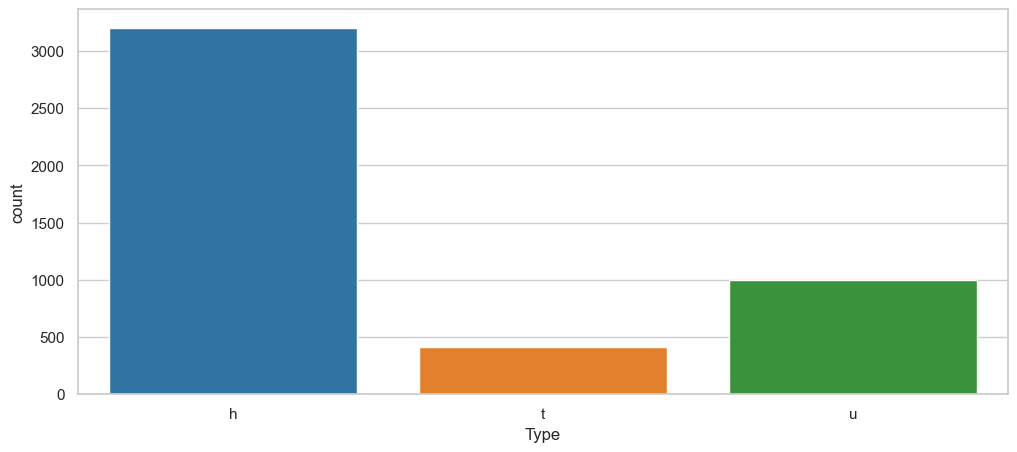

In [24]:
sns.countplot(x='Type', data=train_set)

<AxesSubplot:xlabel='Longtitude', ylabel='Lattitude'>

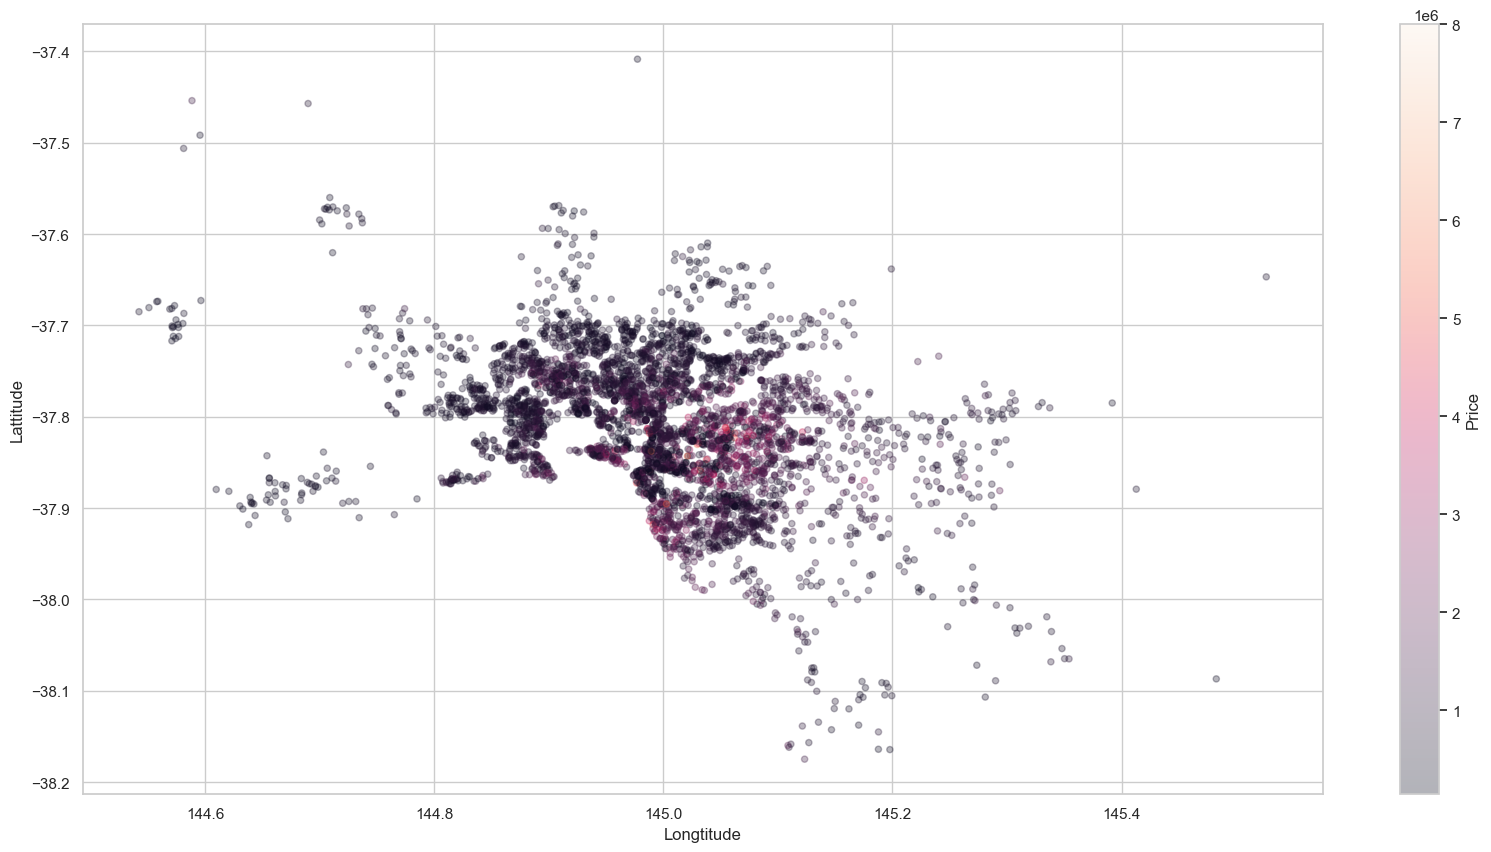

In [26]:
train_set.plot(
    kind='scatter',
    x='Longtitude',
    y='Lattitude',
    alpha=.3,
    figsize=(20, 10),
    c='Price', 
    cmap=plt.get_cmap('jet'),
    colorbar=True,
    sharex=False
)

<AxesSubplot:>

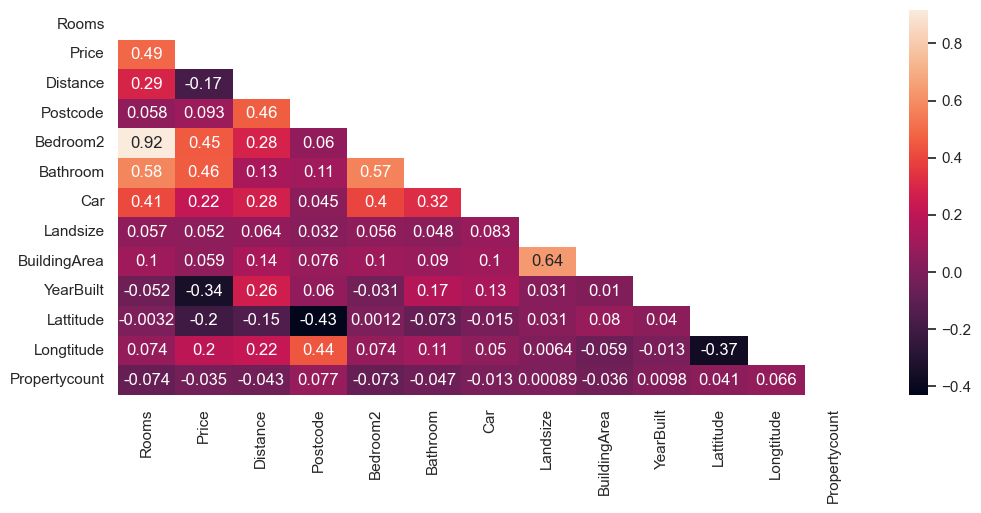

In [28]:
corr = train_set.corr(numeric_only=True)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(
    corr,
    annot=True,
    mask=matrix
)